# Machine Learning Final Project

## Step 0: Project Ideation & Dataset Inspection

### Instructions
1. **Dataset Loading**:

    - For each plan (e.g., Plan A, Plan B, etc.), read in the corresponding dataset.

2. **Inspect the Dataset**:

    - After loading the dataset, display the first few rows to understand its structure.

    - Identify and list the types of fields (e.g., numerical, categorical, text).

    - Attempt to identify the target variable if your project involves supervised learning.

### Plan A: Animal drug use adverse event

In [1]:
# # Your code here
# import pandas as pd
# import re
# import requests

# # Define the base URL and initial query parameters
# url = 'https://api.fda.gov/animalandveterinary/event.json?'
# search = 'search=drug.active_ingredients.name:"Moxidectin"&limit=1000'
# url = url + search

# results = []

# while True:
#     # Make the request to the API
#     a = requests.get(url)
#     data = a.json()
    
#     # Convert the JSON response to a DataFrame and select specific columns
#     df = pd.DataFrame(data['results'])
#     df = df[['treated_for_ae', 'reaction', 'time_between_exposure_and_onset', 'drug', 'health_assessment_prior_to_exposure', 'onset_date', 'animal', 'type_of_information', 'serious_ae', 'outcome']]
#     results.append(df)
    
#     # Try to get the next page URL from the 'Link' header
#     try:
#         link_header = a.headers.get('Link', '')
#         b = re.search(r'<(https[^>]+)>', link_header)
#         if b:
#             next_url = b.group(1)
#             url = next_url
#         else:
#             break
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         break

# # Concatenate all DataFrames into one
# df_combined = pd.concat(results, axis=0)

# # Print information about the final DataFrame
# df_combined.info()

In [2]:
# # Inspect the first five rows
# df_combined.head()

In [3]:
# df_combined.shape

Because some of the fields are JSON objects, we want to further inspect them. 

We will want to parse these JSON objects in a way that is ingestible for our model. This will occur during EDA.

In [4]:
# row_index = 0
# column_label = 'outcome'
# df_combined.iloc[row_index][column_label]

### Plan B: Biomedical Image Analysis

In [5]:
# TODO: Uncomment if not installed
# !pip install medmnist

Loading the dataset:

In [48]:
# Your code here
import medmnist
from medmnist import INFO
import numpy as np
import pandas as pd
import torchvision.transforms as transforms

# Download the dataset
data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load training and testing datasets
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Inspect the dataset
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Using downloaded and verified file: /home/vscode/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/vscode/.medmnist/pathmnist.npz
Train dataset size: 89996
Test dataset size: 7180


Summary:

- `transforms.Compose([...])`: This function allows you to chain multiple transformations together. In this case, two transformations are applied to the data:

    - `transforms.ToTensor()`: Converts a PIL Image or NumPy array into a PyTorch tensor. This is necessary because neural networks in PyTorch work with tensors.

    - `transforms.Normalize(mean=[.5], std=[.5])`: Normalizes the tensor data. Here, it normalizes the input by subtracting the mean and dividing by the standard deviation. This helps in stabilizing and speeding up the training process.

- `DataClass`: This is a placeholder for your dataset class, which is responsible for loading and potentially transforming the data. 

    - `split='train'` or `'test'`: Specifies whether to load the training or test data

    - `transform=data_transform`: Applies the transformation defined earlier (converting to tensor and normalizing) to each sample in the dataset.

    - `download=download`: If the dataset is not available locally, it will be downloaded.

Encapsulating data into `data.DataLoader`:

In [49]:
import torch.utils.data as data

BATCH_SIZE = 128

# Example of loading the dataset into a DataLoader
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Summary:

- `data.DataLoader`: This wraps the dataset into a DataLoader object, which provides an iterator to iterate over the dataset in mini-batches.

    - `data.DataLoader` is essential for handling data efficiently in PyTorch, particularly when dealing with large datasets. It batches the data, optionally shuffles it, and loads it in a way that can be processed by your model.

    - `dataset=train_dataset` or `test_dataset`: Specifies the dataset to load from.

    - `batch_size=BATCH_SIZE`: Defines how many samples are loaded per batch. This is crucial for training neural networks, as it allows for gradient updates over multiple samples at once rather than one at a time.

    - `shuffle=True` or `False`: Determines whether the data should be shuffled before being passed to the model. Shuffling is generally enabled during training to ensure that the model doesn't learn the order of the data. During evaluation, shuffling is typically turned off.

Convert `train_dataset` and `test_dataset` into Dataframes, `train_df` and `test_df`. We can store these dataframes in a SQL databases for safekeeping (Step 3).

In [50]:
from tqdm import tqdm

# Load data from `train_dataset` and `test_dataset` using `tqdm`
train_data = [(np.array(img), label) for img, label in tqdm(train_dataset)]
test_data = [(np.array(img), label) for img, label in tqdm(test_dataset)]

# Convert `train_data` and `test_data` to DataFrame
train_df = pd.DataFrame(train_data, columns=['img', 'label'])
test_df = pd.DataFrame(test_data, columns=['img', 'label'])

# Inspect train_df
train_df.head()

100%|██████████| 7180/7180 [00:01<00:00, 4907.84it/s]


,img,label
0,"[[[0.7254902, 0.7176471, 0.7254902, 0.73333335...",[0]
1,"[[[-0.011764705, 0.11372554, 0.36470592, 0.513...",[4]
2,"[[[0.7490196, 0.7490196, 0.70980394, 0.6470588...",[7]
3,"[[[0.69411767, 0.69411767, 0.67058825, 0.71764...",[5]
4,"[[[0.6, 0.6, 0.654902, 0.69411767, 0.654902, 0...",[5]


Each row represents an image and its corresponding label. The values you see under `img` are the normalized pixel values of the images. These arrays are typically multi-dimensional, with each dimension corresponding to different properties of the image. Let's inspect a single image,

In [51]:
# Select an index to view
index = 4  # Change this to view a different image

# From the train_dataset
image, label = train_dataset[index]
label = label.item()

# Convert image to numpy array if needed
image = np.array(image)
image

array([[[ 0.6       ,  0.6       ,  0.654902  , ...,  0.69411767,
          0.75686276,  0.827451  ],
        [ 0.62352943,  0.6392157 ,  0.60784316, ...,  0.69411767,
          0.78039217,  0.84313726],
        [ 0.77254903,  0.6862745 ,  0.6627451 , ...,  0.62352943,
          0.654902  ,  0.79607844],
        ...,
        [ 0.69411767,  0.6156863 ,  0.6784314 , ...,  0.7019608 ,
          0.7176471 ,  0.7647059 ],
        [ 0.64705884,  0.70980394,  0.7882353 , ...,  0.6862745 ,
          0.7176471 ,  0.78039217],
        [ 0.8117647 ,  0.7882353 ,  0.8117647 , ...,  0.52156866,
          0.7019608 ,  0.79607844]],

       [[-0.02745098, -0.09019607,  0.1686275 , ...,  0.20000005,
          0.45098042,  0.654902  ],
        [ 0.03529418,  0.10588241, -0.00392157, ...,  0.20000005,
          0.4901961 ,  0.7019608 ],
        [ 0.4039216 ,  0.22352946,  0.17647064, ...,  0.10588241,
          0.20784318,  0.5372549 ],
        ...,
        [ 0.3411765 ,  0.18431377,  0.27058828, ...,  

The images are in color because the array is 3D with dimensions `(channels, height, width)`, where `channels` is usually 3 (representing the Red, Green, and Blue color channels). Each element in the array represents the intensity of the corresponding color channel for a pixel.

Below we can see that the images are 28x28 pixels and RGB (in color),

In [52]:
np.shape(image)

(3, 28, 28)

These arrays are used as input for machine learning models, where the model processes these pixel values to learn patterns and make predictions based on the images.

Lets use `matplotlib` to render the image from the pixel data. To display an image using `matplotlib`, you need to ensure the image is in the correct format. `matplotlib` expects the image in the format `(height, width, channels)` (i.e., (28, 28, 3)), so we need need to transpose the dimensions of the array.

*Note: Normalization was reversed to display the original image*

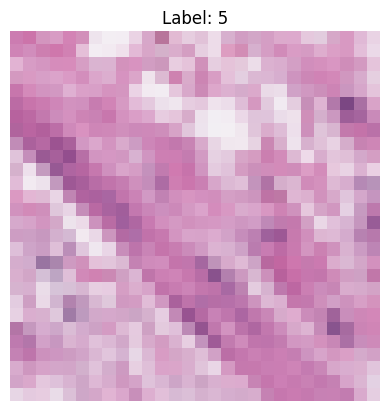

In [53]:
import matplotlib.pyplot as plt

# Reverse the normalization: Since you used mean=[.5], std=[.5], reverse it using the formula:
image = image * 0.5 + 0.5

# Transpose the image to match Matplotlib's expected format (H, W, C)
image = np.transpose(image, (1, 2, 0))

# Display the image
plt.imshow(image)
plt.title(f'Label: {label}')
plt.axis('off')  # Turn off axis labels

plt.show()

Inspect 9 random images with their associated label,

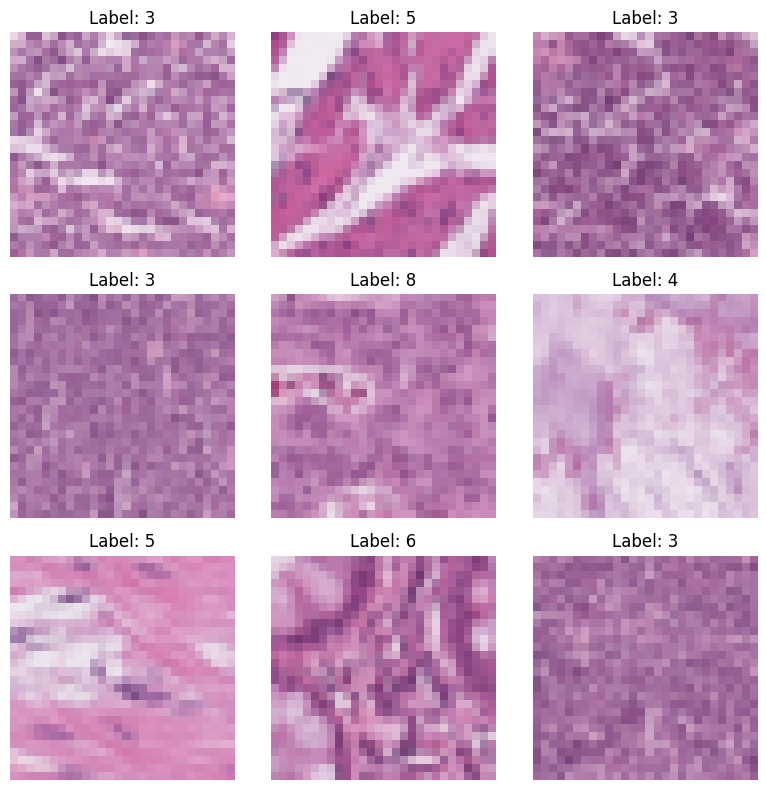

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Select 9 random indices
random_indices = random.sample(range(len(train_dataset)), 9)

# Create a 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop over the 9 random indices and display each image
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[random_indices[i]]
    label = label.item()

    # Reverse the normalization: Since you used mean=[.5], std=[.5], reverse it using the formula:
    image = image * 0.5 + 0.5

    # Convert PyTorch tensor to NumPy array
    image = image.numpy()

    # Transpose the image to match Matplotlib's expected format (H, W, C)
    image = np.transpose(image, (1, 2, 0))

    # Ensure the image data is in the correct format
    image = np.clip(image, 0, 1)  # Clip to range [0, 1] if it's a float image

    # Ensure the directory for saving images exists
    save_dir = f'../data/raw/Class {label}'
    os.makedirs(save_dir, exist_ok=True)

    # Save the image with a unique index
    filename = f'{save_dir}/image_{random_indices[i]}.png'
    plt.imsave(filename, image)

    # Display the image
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [55]:
# Extract all labels from the train_dataset
labels = [label.item() for _, label in train_data]

# Get unique labels
unique_labels = list(set(labels))

# Print unique labels
print("Unique labels:", unique_labels)

Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8]


Mapping of the labels:

In [56]:
print(info['label'])

{'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


### Plan C: Website Fact Checker

In [57]:
# Your code here

## Step 1: Problem definition

### Instructions

1. **Select a Project Plan:**

    - Review the dataset options from Plan A, Plan B, and Plan C.

    - Choose one of the plans to move forward with based on your dataset inspection and interest.

2. **Write a Project Description:**

    - Clearly define the problem or question you intend to address with your selected dataset.

    - Consider how your chosen dataset can help solve this problem or answer the question.

    - Write a one-sentence description that clearly states the objective of your project. This should include what you aim to achieve or understand with the dataset.

3. **Name the Project:**

    - Create a name for your project that reflects the focus of your work.

### 1. Select a Project Plan

Plan B: Predicting Colon Cancer Histology Slide Content Using Deep Learning

### 2. Write a Project Description

Problem Definition:
The project aims to develop a machine learning model capable of accurately predicting the content of histology slides related to colon cancer. This involves analyzing images of colon cancer tissue to identify specific features and patterns that can indicate the presence and type of cancerous cells. The dataset comprises 100,000 non-overlapping image patches, each representing one of nine classes: adipose tissue (ADI), background (BACK), debris (DEB), lymphocyte (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), and CRC Epithelium (TUM). Accurately classifying these image patches is crucial for aiding in the diagnosis and treatment planning of colon cancer.

Dataset Utilization:
The chosen dataset from MedMNIST.com provides a collection of labeled histology images specific to colon cancer. By training the model on this dataset, we aim to create a tool that can assist pathologists in diagnosing colon cancer more effectively.

Objective:
The objective of this project is to use deep learning techniques to classify and predict the contents of colon cancer histology slides, ultimately aiding in the early and accurate detection of colon cancer.

### 3. Name the Project

Project Title: Predicting Colon Cancer Histology Slide Content Using Deep Learning

## Step 2: Acquiring and loading the data set

### Instructions

1. **Acquiring the Dataset:** Describe how you have acquired the dataset for your project. Depending on the method you used:

    1. **Web Scraping:**

        - If you used web scraping, provide details about the website or web page from which you extracted data.

        - Include information on the tools or libraries you used for scraping (e.g., BeautifulSoup, Scrapy).

        - Mention any challenges faced during the scraping process and how you addressed them.

    2. **SQL Database:**

        - If you obtained data from a public database using SQL, specify the database you accessed.

        - Describe the SQL queries you used to extract the data.

        - Include any relevant details about the database schema and how you navigated it.

    3. **Public API:**

        - If you accessed data through a public API, provide details about the API.

        - Describe the API endpoints you used and any parameters or filters applied to your requests.

        - Mention the format of the data returned by the API and how you processed it.

2. **Loading the Dataset:**

    - Detail the steps you followed to load the dataset into your working environment.

    - Describe the tools or libraries used for loading the data (e.g., `Pandas` for CSV files, `SQLAlchemy` for SQL databases, `requests` or an API client library for APIs).

    - Include any data cleaning or preprocessing steps you performed to prepare the data for analysis.

3. **Document Your Process:**

    - Provide a brief summary of your data acquisition and loading process, highlighting any key steps or decisions.

    - Include any challenges or issues encountered and how you resolved them.

There is a premade package that we have downloaded and used the documentation to dowload all of the images and set them up in an SQL database.  Though, honestly, using the prebuilt custom DataLoader class based in pytorch will likely be much more sensible for our purposes, as it will automatically batch the images and take care of much of the headache.

## Step 3: Store the information

### Instructions

1. **Choose a Database:**

    - Select a database that is most compatible with your dataset. Consider factors such as the size of the data, the complexity of the queries you plan to perform, and the features offered by the database.

    - The databases we have studied include SQLite, PostgreSQL, MySQL, etc.

2. **Store the Data:**

    - Import the dataset into the chosen database. This may involve creating tables and defining schemas that match the structure of your data.

    - Ensure that the database is properly set up to handle the data efficiently. Consider indexing or other optimizations if necessary.

3. **Perform Queries:**

    - Write and execute SQL queries to interact with your stored data. Use the following types of queries:

        - `SELECT`: Retrieve specific data from your tables. For example, you can select columns or rows that meet certain criteria.

        - `JOIN`: Combine data from multiple tables based on related columns to perform more complex queries.

        - `INSERT`: Add new data to your tables if necessary.

        - Include any other relevant SQL operations that are useful for your analysis.
    
    - Alternatively, use Python wrappers for SQL (e.g., `SQLAlchemy`, `pandas`) if applicable. These wrappers can help you perform SQL operations more easily within a Python environment.

4. **Document Your Process:**

    - Provide a summary of how you stored your data in the database, including the database used and the structure of the tables.

    - Include examples of the SQL queries you wrote and explain how they help in starting the analysis.

    - Discuss any challenges faced during the data storage and querying process and how you addressed them.

In [58]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('../Bump/DBIITheReckoning.db')

# Commented out to save time
# train_df.to_sql('Train_Data', conn, if_exists='replace', index=False)
# test_df.to_sql('Test_Data', conn, if_exists='replace', index=False)

1. Write a SQL `SELECT` statement to retrieve the first 10 rows from your training set table &

2. Write a SQL `SELECT` statement to retrieve the first 10 rows from your test set table:

In [59]:
# Initialize an empty list to store dataframes
dfs = []

cursor = conn.cursor()
query = 'SELECT * FROM {} LIMIT 10'
for i in ['Train_Data', 'Test_Data']:
    que = query.format(i)  # Format the query string with the table name
    cursor.execute(que)

    # Fetch all the records and convert them to a dataframe
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

    # Convert the byte data back into numpy arrays
    # Adjust dtype and shape as per your data
    def decode_image_data(byte_data, shape=(3, 28, 28), dtype=np.float32):
        array = np.frombuffer(byte_data, dtype=dtype)
        return array.reshape(shape)

    # Convert the byte data back into numpy arrays
    df['img'] = df['img'].apply(lambda x: decode_image_data(x, shape=(3, 28, 28), dtype=np.float32))
    df['label'] = df['label'].apply(lambda x: np.frombuffer(x, dtype=np.int64))  # Adjust dtype as per your data

    # Append the dataframe to the list
    dfs.append(df)

Inspect the retrieved data and ensure they match the inputs `train_df` and `test_df`,

In [60]:
retrieved_train_data = dfs[0]
retrieved_train_data

,img,label
0,"[[[0.7254902, 0.7176471, 0.7254902, 0.73333335...",[0]
1,"[[[-0.011764705, 0.11372554, 0.36470592, 0.513...",[4]
2,"[[[0.7490196, 0.7490196, 0.70980394, 0.6470588...",[7]
3,"[[[0.69411767, 0.69411767, 0.67058825, 0.71764...",[5]
4,"[[[0.6, 0.6, 0.654902, 0.69411767, 0.654902, 0...",[5]
5,"[[[0.5764706, 0.60784316, 0.58431375, 0.396078...",[8]
6,"[[[0.36470592, 0.36470592, 0.49803925, 0.60784...",[3]
7,"[[[0.1686275, 0.56078434, 0.22352946, 0.278431...",[3]
8,"[[[0.5764706, 0.58431375, 0.5294118, 0.5686275...",[5]
9,"[[[0.5372549, 0.5764706, 0.5529412, 0.54509807...",[2]


In [61]:
retrieved_test_data = dfs[1]
retrieved_test_data

,img,label
0,"[[[0.4901961, 0.34901965, 0.19215691, 0.050980...",[8]
1,"[[[0.5686275, 0.39607847, 0.38823533, 0.364705...",[4]
2,"[[[0.8666667, 0.81960785, 0.8039216, 0.7490196...",[4]
3,"[[[0.5372549, 0.5372549, 0.654902, 0.5294118, ...",[8]
4,"[[[0.827451, 0.7254902, 0.62352943, 0.67058825...",[4]
5,"[[[0.7176471, 0.70980394, 0.60784316, 0.443137...",[4]
6,"[[[0.058823586, 0.45882356, 0.7490196, 0.85882...",[8]
7,"[[[0.84313726, 0.84313726, 0.827451, 0.8352941...",[0]
8,"[[[0.027451038, -0.0039215684, 0.19215691, 0.4...",[6]
9,"[[[0.92156863, 0.92941177, 0.92156863, 0.89019...",[8]


## Step 4 & 5: Perform a descriptive analysis & full EDA

1. **Getting the Dimensions of the Dataframe**

    - Get the dimensions of the `train_df`. This will give you the number of rows (images) and columns in the dataframe.

In [62]:
train_df.shape

(89996, 2)

$~~~~~~~~~~$- Get the dimensions of `test_df`.

In [63]:
test_df.shape

(7180, 2)

2. **Checking for Missing Values**

    - Check and count how many rows have missing values in `train_df`. Drop/remove rows with missing values if any.

In [64]:
# Your code here
# Check for missing values in each column
missing_values = train_df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Count the total number of rows with any missing values
rows_with_missing_values = train_df.isnull().any(axis=1).sum()
print(f'Total number of rows with missing values: {rows_with_missing_values}')

Missing values per column:
 img      0
label    0
dtype: int64
Total number of rows with missing values: 0


$~~~~~~~~~~$- Check and count how many rows have missing values in `test_df`. Drop/remove rows with missing values if any.

In [65]:
# Your code here
# Check for missing values in each column
missing_values = test_df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Count the total number of rows with any missing values
rows_with_missing_values = test_df.isnull().any(axis=1).sum()
print(f'Total number of rows with missing values: {rows_with_missing_values}')

Missing values per column:
 img      0
label    0
dtype: int64
Total number of rows with missing values: 0


3. **Checking the Data Types of Columns**

    - Check the data type of of each column in the `train_df` DataFrame.

In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89996 entries, 0 to 89995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     89996 non-null  object
 1   label   89996 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


$~~~~~~~~~~$- Check the data type of of each column in the `test_df` DataFrame.

In [67]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7180 entries, 0 to 7179
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     7180 non-null   object
 1   label   7180 non-null   object
dtypes: object(2)
memory usage: 112.3+ KB


4. **Inspect the Data Type of `img`**

    - Inspect the data type of an individual `img` from `train_df`.

In [68]:
first_train_img = train_df['img'].iloc[0]
type(first_train_img)

print(f"Shape of the first image: {first_train_img.shape}")
print(f"Data type of the first image: {type(first_train_img)}")

Shape of the first image: (3, 28, 28)
Data type of the first image: <class 'numpy.ndarray'>


$~~~~~~~~~~$- Inspect the data type of an individual `img` from `test_df`.

In [69]:
first_test_img = test_df['img'].iloc[0]
type(first_test_img)

print(f"Shape of the first test image: {first_test_img.shape}")
print(f"Data type of the first test image: {type(first_test_img)}")

Shape of the first test image: (3, 28, 28)
Data type of the first test image: <class 'numpy.ndarray'>


5. **Inspect the Data Type of `label`**

    - Inspect the data type of an individual `label` from `train_df`.

    - Inspect the data type of an individual `label` from `test_df`.

In [70]:
for i in [train_df, test_df]:
    print(type(i['label'].iloc[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


6. **Casting the Label to an Integer**

    - Convert the `label` column from an array to an integer for `train_df`.

    - Convert the `label` column from an array to an integer for `test_df`.

In [71]:
# Convert the label column from an array to an integer in train_df
train_df['label'] = train_df['label'].apply(lambda x: int(x[0]))

# Convert the label column from an array to an integer in test_df
test_df['label'] = test_df['label'].apply(lambda x: int(x[0]))

In [72]:
for i in [train_df, test_df]:
    print(type(i['label'].iloc[0]))

<class 'numpy.int64'>
<class 'numpy.int64'>


Verifying that the data type of the `label` column is now an integer,

In [73]:
# Get the first train image label
first_train_img_label = train_df['label'].iloc[0]

print(f"First train img label: {first_train_img_label}")
print(f"Data type of first train img label: {type(first_train_img_label)}")

First train img label: 0
Data type of first train img label: <class 'numpy.int64'>


In [74]:
# Get the first test image label
first_test_img_label = test_df['label'].iloc[0]

print(f"First test img label: {first_test_img_label}")
print(f"Data type of first train img label: {type(first_test_img_label)}")

First test img label: 8
Data type of first train img label: <class 'numpy.int64'>


7. **Getting the Label Distribution**

    - Count the number of instances for each `label` in `train_df`.

In [75]:
train_df['label'].value_counts()

label
8    12885
5    12182
3    10401
2    10360
1     9509
7     9401
0     9366
4     8006
6     7886
Name: count, dtype: int64

$~~~~~~~~~~$- Count the number of instances for each `label` in `test_df`.

In [76]:
test_df['label'].value_counts()

label
0    1338
8    1233
4    1035
1     847
6     741
3     634
5     592
7     421
2     339
Name: count, dtype: int64

8. **Visualizing the Label Distribution**

    - Visualize the `label` distribution for `train_df` using a bar plot or histogram.

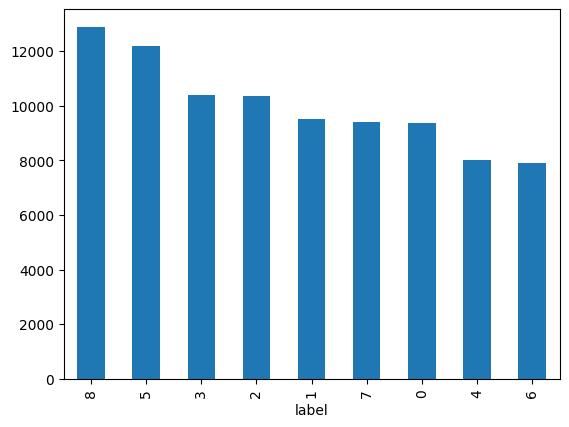

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

bar = train_df['label'].value_counts().plot(kind='bar')
plt.show()

$~~~~~~~~~~$- Visualize the `label` distribution for `test_df` using a bar plot or histogram.

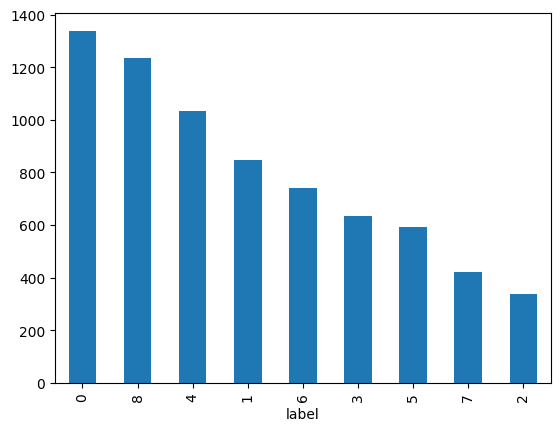

In [78]:
bar_nun = test_df['label'].value_counts().plot(kind='bar')
plt.show()

9. **Getting Image Dimensions**

    - Check the dimensions of the images to ensure consistency across the `train_df` dataset.

In [79]:
# Extract the dimensions of each image in the train_df
image_dimensions = train_df['img'].apply(lambda x: x.shape)

# Display unique dimensions to check for consistency
unique_dimensions = image_dimensions.unique()
print(f"Unique image dimensions: {unique_dimensions}")


Unique image dimensions: [(3, 28, 28)]


$~~~~~~~~~~$- Check the dimensions of the images to ensure consistency across the `test_df` dataset.

In [80]:
# Extract the dimensions of each image in the train_df
image_dimensions = test_df['img'].apply(lambda x: x.shape)

# Display unique dimensions to check for consistency
unique_dimensions = image_dimensions.unique()
print(f"Unique image dimensions: {unique_dimensions}")


Unique image dimensions: [(3, 28, 28)]


10. **Getting Pixel Intensity Statistics**

    - Calculate basic statistics (mean, standard deviation, min, max) of pixel intensities across all images in `train_df`.

In [81]:
import numpy as np

funcs = {'avg':np.mean, 'std':np.std, 'min':np.min, 'max':np.max}
for k, v in funcs.items():
    train_df[k] = train_df['img'].apply(v)

Inspect `train_df` with the newly created columns (the aggregations),

In [82]:
train_df

,img,label,avg,std,min,max
0,"[[[0.7254902, 0.7176471, 0.7254902, 0.73333335...",0,0.695545,0.083301,0.286275,0.788235
1,"[[[-0.011764705, 0.11372554, 0.36470592, 0.513...",4,0.350800,0.242469,-0.631373,0.843137
2,"[[[0.7490196, 0.7490196, 0.70980394, 0.6470588...",7,0.485701,0.203110,-0.372549,0.858824
3,"[[[0.69411767, 0.69411767, 0.67058825, 0.71764...",5,0.380172,0.269259,-0.325490,0.835294
4,"[[[0.6, 0.6, 0.654902, 0.69411767, 0.654902, 0...",5,0.467240,0.261426,-0.443137,0.905882
...,...,...,...,...,...,...
89991,"[[[0.7254902, 0.7176471, 0.7176471, 0.7176471,...",0,0.595598,0.202713,-0.741176,0.788235
89992,"[[[0.52156866, 0.5529412, 0.5137255, 0.6, 0.6,...",6,0.477034,0.228047,-0.411765,0.905882
89993,"[[[0.5764706, 0.58431375, 0.49803925, 0.560784...",2,0.320782,0.238570,-0.286274,0.709804
89994,"[[[0.77254903, 0.7647059, 0.5058824, -0.239215...",0,0.680969,0.181265,-0.654902,0.803922


$~~~~~~~~~~$- Calculate basic statistics (mean, standard deviation, min, max) of pixel intensities across all images in `test_df`.

In [83]:
for k, v in funcs.items():
    test_df[k] = test_df['img'].apply(v)

test_df

,img,label,avg,std,min,max
0,"[[[0.4901961, 0.34901965, 0.19215691, 0.050980...",8,0.080856,0.339828,-0.756863,0.913725
1,"[[[0.5686275, 0.39607847, 0.38823533, 0.364705...",4,0.355969,0.243152,-0.545098,0.819608
2,"[[[0.8666667, 0.81960785, 0.8039216, 0.7490196...",4,0.505562,0.223927,-0.490196,0.866667
3,"[[[0.5372549, 0.5372549, 0.654902, 0.5294118, ...",8,0.290329,0.309868,-0.584314,0.929412
4,"[[[0.827451, 0.7254902, 0.62352943, 0.67058825...",4,0.536581,0.344740,-0.788235,0.898039
...,...,...,...,...,...,...
7175,"[[[0.4901961, 0.20784318, 0.18431377, 0.466666...",8,0.039753,0.303229,-0.686275,0.850980
7176,"[[[0.47450984, 0.4039216, 0.49803925, 0.662745...",7,0.419521,0.258381,-0.545098,0.921569
7177,"[[[0.35686278, 0.5686275, 0.39607847, 0.443137...",4,0.364816,0.198056,-0.349020,0.756863
7178,"[[[0.035294175, -0.035294116, 0.09803927, 0.36...",8,0.167647,0.401613,-0.725490,0.913725


11. **Analyzing a Correlation Between Image Intensity and Labels**

    - Analyze if there is any relationship between the average pixel intensity of an image and its label for `train_df`.

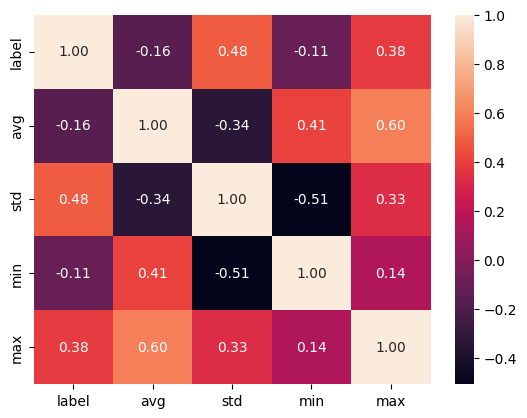

In [84]:
corr = train_df.drop(columns='img').corr()
sns.heatmap(corr, annot=True, fmt='.2f', cbar=True)
plt.show()

$~~~~~~~~~~$- Analyze if there is any relationship between the average pixel intensity of an image and its label for `test_df`.

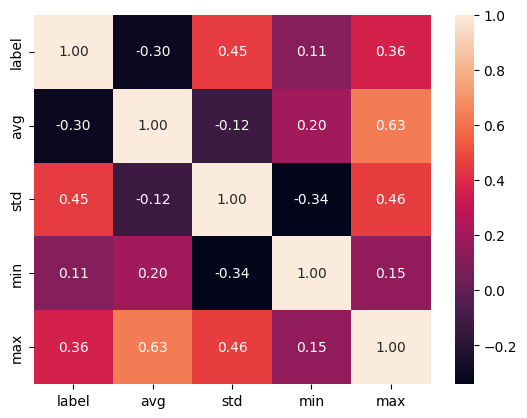

In [85]:
corr = test_df.drop(columns='img').corr()
sns.heatmap(corr, annot=True, fmt='.2f', cbar=True)
plt.show()

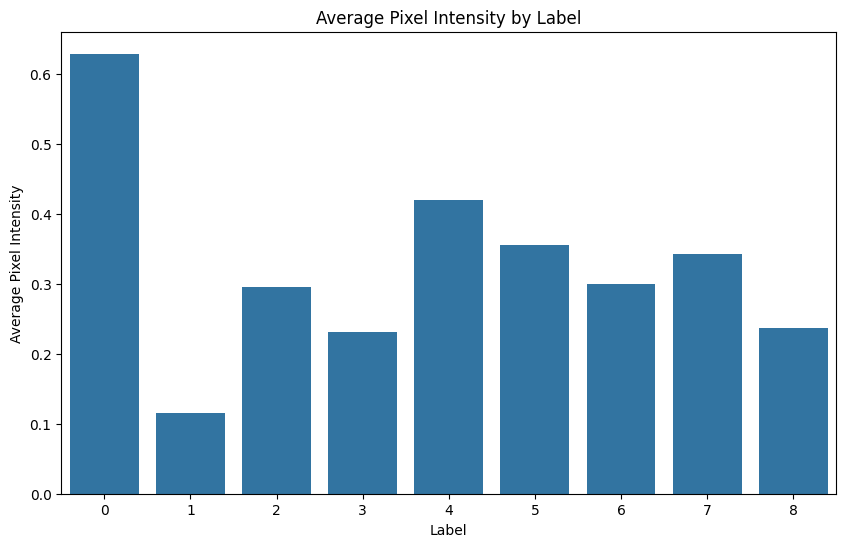

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by label and calculate the mean of average pixel intensity
label_intensity_mean = train_df.groupby('label')['avg'].mean()

# Plot the relationship between label and average pixel intensity
plt.figure(figsize=(10, 6))
sns.barplot(x=label_intensity_mean.index, y=label_intensity_mean.values)
plt.title('Average Pixel Intensity by Label')
plt.xlabel('Label')
plt.ylabel('Average Pixel Intensity')
plt.show()

## Step 6: Build the model and optimize it

### 6.1 Set Up the Model
Let's assume we're working with a simple neural network model for image classification.

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from model_module import SimpleCNN

# Saved this class in a separate module `model_module.py`
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Changed in_channels to 3
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(in_features=64*7*7, out_features=128)  # Updated in_features to match the output size after pooling
#         self.fc2 = nn.Linear(in_features=128, out_features=10)  # Assuming 10 classes

#     def forward(self, x):
#         x = nn.functional.relu(self.conv1(x))
#         x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
#         x = nn.functional.relu(self.conv2(x))
#         x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
#         x = x.view(-1, 64*7*7)  # Flatten the tensor
#         x = nn.functional.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# Instantiate the model
model = SimpleCNN()

Summary:

- **Model Definition (`SimpleCNN`)**: This is a simple convolutional neural network (CNN) with two convolutional layers followed by fully connected layers.

### 6.2 Define the Loss Function and Optimizer
We'll use CrossEntropyLoss (common for classification tasks) and the Adam optimizer.

In [88]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Summary:

- **Loss Function & Optimizer**: The `CrossEntropyLoss` is used for multi-class classification, and `Adam` is a popular optimizer that adjusts the learning rate during training.

### 6.3 Training Loop
Now, we'll train the model using the `train_loader`.

In [89]:
# Set the model to training mode
model.train()

# Number of epochs to train
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Squeeze labels to the correct shape
        labels = labels.squeeze(1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if batch_idx % 100 == 99:  # Print every 100 batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print('Finished Training')

Epoch [1/10], Step [100/704], Loss: 1.4714
Epoch [1/10], Step [200/704], Loss: 0.9929
Epoch [1/10], Step [300/704], Loss: 0.8309
Epoch [1/10], Step [400/704], Loss: 0.7193
Epoch [1/10], Step [500/704], Loss: 0.6797
Epoch [1/10], Step [600/704], Loss: 0.6307
Epoch [1/10], Step [700/704], Loss: 0.6086
Epoch [2/10], Step [100/704], Loss: 0.5995
Epoch [2/10], Step [200/704], Loss: 0.5723
Epoch [2/10], Step [300/704], Loss: 0.5536
Epoch [2/10], Step [400/704], Loss: 0.5375
Epoch [2/10], Step [500/704], Loss: 0.5112
Epoch [2/10], Step [600/704], Loss: 0.5022
Epoch [2/10], Step [700/704], Loss: 0.5007
Epoch [3/10], Step [100/704], Loss: 0.4899
Epoch [3/10], Step [200/704], Loss: 0.4625
Epoch [3/10], Step [300/704], Loss: 0.4421
Epoch [3/10], Step [400/704], Loss: 0.4479
Epoch [3/10], Step [500/704], Loss: 0.4172
Epoch [3/10], Step [600/704], Loss: 0.4112
Epoch [3/10], Step [700/704], Loss: 0.4171
Epoch [4/10], Step [100/704], Loss: 0.3763
Epoch [4/10], Step [200/704], Loss: 0.3934
Epoch [4/10

Summary:
- The model is trained over multiple epochs.

- For each batch, the model's parameters are updated using backpropagation to minimize the loss

- We print the loss periodically to monitor the training process.

### 6.4 Evaluation Loop
After training, we can evaluate the model on the test dataset.

In [90]:
# Set the model to evaluation mode
model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Squeeze labels to the correct shape
        labels = labels.squeeze(1)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Calculate the number of correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the accuracy
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Accuracy of the model on the test images: 81.59%


Summary:

- After training, the model's performance is evaluated on the test set.

- The accuracy of the model on the test data is calculated and displayed.

### 6.5 Make predictions
To use your model to predict the class of an image that you have saved locally, you'll need to perform the following steps:

#### 1. Preprocess the Image
Since your model expects images with 3 channels (RGB) and your saved image has 4 channels (RGBA), you need to handle the alpha channel and ensure the image is in the correct format.

Here’s how you can preprocess your image:

In [91]:
from PIL import Image
import torchvision.transforms as transforms

# Define the preprocessing transformation
data_transform = transforms.Compose([
    transforms.Resize((28, 28)),       # Ensure the image is 28x28
    transforms.ToTensor(),             # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Same normalization as used during training
])

# Load and preprocess the image
folder_name = "Class 0"  # Feel free to change the folder
image_name = "image_88405.png"  # Feel free to change the image
image_path = f'../data/raw/{folder_name}/{image_name}'
image = Image.open(image_path).convert('RGB')  # Convert to RGB to match model input

# Apply the preprocessing transformations
image_tensor = data_transform(image).unsqueeze(0)  # Add batch dimension

# Check the shape of the processed image tensor
print(image_tensor.shape)  # Should be (1, 3, 28, 28)

torch.Size([1, 3, 28, 28])


#### 2. Run the Model Inference
Load your trained model and use it to predict the class of the preprocessed image:

In [92]:
# Ensure the model is in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    # Forward pass
    outputs = model(image_tensor)
    # Get the predicted class
    _, predicted = torch.max(outputs, 1)

# Print the predicted class
label_mapping = info["label"]
print("Label mapping:")
print(label_mapping)
print()

predicted_label = predicted.item()
print(f'Predicted class: {predicted_label} ({label_mapping[f"{predicted_label}"]})')

Label mapping:
{'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}

Predicted class: 0 (adipose)


Summary:

- **Image Conversion**: Convert the image to RGB since your model expects 3 channels.

- **Image Transformation**: Apply the same preprocessing steps used during training: resizing, tensor conversion, and normalization.

- **Model Inference**: Use the model to predict the class of the image by passing the preprocessed image through it.

### 6.6 Save your model

In [93]:
import pickle

# Save the trained model as a pickle file
with open('trained_cnn.pkl', 'wb') as f:
    pickle.dump(model, f)

print('Model saved as trained_cnn.pkl')

Pipeline saved as trained_cnn.pkl
